In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
class conv_block (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding):

        super(conv_block, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU6()

    def forward(self, X):

        out = self.relu(self.bn(self.conv(X)))

        return out

class depthwise_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, groups=1):
        super(depthwise_block, self).__init__()

        # dw

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                               kernel_size=(3, 3),
                               stride=stride,
                               padding=(1, 1),
                               groups=groups
                               )

        self.bn1 = nn.BatchNorm2d(num_features=in_channels)
        self.relu = nn.ReLU()  # should have used ReLU6!

        # pw

        self.conv2 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(1, 1),
                               stride=(1, 1),
                               padding=(0, 0),
                               )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, X):
        out = self.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))

        # mobilev2 doesnt have relu in pw

        return out

class InvertedResidual_block (nn.Module):
    def __init__(self, in_channels, out_channels, stride, block_type1=False,
                 expand_ratio=6):
        super(InvertedResidual_block, self).__init__()

        assert block_type1 == True or block_type1 == False
        self.block_type = block_type1

        # expansion

        self.conv1 = conv_block(in_channels=in_channels,
                               out_channels=in_channels*expand_ratio,
                                kernel_size=(1,1),
                               stride=(1,1),
                                padding=(0,0))

        # depthwise_block = depthwise + pointwise

        self.convdw = depthwise_block(in_channels=in_channels*expand_ratio,
                                      out_channels=out_channels,
                                      stride=stride,
                                      groups=in_channels*expand_ratio)

        if block_type1:
            self.padd_conv = nn.Conv2d(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=(1, 1),
                                       stride=(1, 1),
                                       padding=(0, 0))


    def forward(self, X):

        out = self.conv1(X)
        out = self.convdw(out)

        if self.block_type:
            X = self.padd_conv(X)
            out += X
            return out
        else:
            return out


class MobilenetV2 (nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MobilenetV2, self).__init__()

        self.conv1 = conv_block(in_channels=in_channels,
                                out_channels=32,
                                kernel_size=(3,3),
                                stride=(2,2),
                                padding=(1,1))

        self.bottleneck1 = InvertedResidual_block(in_channels=32,
                                                  out_channels=16,
                                                  stride=(1,1),
                                                  block_type1=True,
                                                  expand_ratio=1)

        self.bottleneck2 = InvertedResidual_block(in_channels=16,
                                                  out_channels=24,
                                                  stride=(2,2),
                                                  block_type1=False,
                                                  expand_ratio=6)

        self.bottleneck2_2nd = InvertedResidual_block(in_channels=24,
                                                  out_channels=24,
                                                  stride=(1,1),
                                                  block_type1=False,
                                                  expand_ratio=6)

        self.bottleneck3 = InvertedResidual_block(24, 32, (2, 2), False, 6)
        self.bottleneck3_2nd = InvertedResidual_block(32, 32, (1, 1), False, 6)

        self.bottleneck4 = InvertedResidual_block(32, 64, (2, 2), False, 6)
        self.bottleneck4_2nd = InvertedResidual_block(64, 64, (1, 1), False, 6)

        self.bottleneck5 = InvertedResidual_block(64, 96, (1, 1), True, 6)
        self.bottleneck5_2nd = InvertedResidual_block(96, 96, (1, 1), True, 6)

        self.bottleneck6 = InvertedResidual_block(96, 160, (2, 2), False, 6)
        self.bottleneck6_2nd = InvertedResidual_block(160, 160, (1, 1), False, 6)

        self.bottleneck7 = InvertedResidual_block(160, 320, (1, 1), True, 1)

        self.conv2 = conv_block(in_channels=320,
                                out_channels=1280,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=(0, 0))

        self.conv3 = conv_block(in_channels=1280,
                                out_channels=1280,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=(0, 0))

        self.avgpool = nn.AvgPool2d(kernel_size=(7,7),
                                    stride=(1, 1),
                                    padding=(0, 0))

        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(in_features=1280, out_features=num_classes)


    def forward(self, X):

        out = self.conv1(X)
        out = self.bottleneck1(out)

        out = self.bottleneck2(out)
        out = self.bottleneck2_2nd(out)

        out = self.bottleneck3(out)
        out = self.bottleneck3_2nd(out)
        out = self.bottleneck3_2nd(out)

        out = self.bottleneck4(out)
        out = self.bottleneck4_2nd(out)
        out = self.bottleneck4_2nd(out)
        out = self.bottleneck4_2nd(out)

        out = self.bottleneck5(out)
        out = self.bottleneck5_2nd(out)
        out = self.bottleneck5_2nd(out)

        out = self.bottleneck6(out)
        out = self.bottleneck6_2nd(out)
        out = self.bottleneck6_2nd(out)

        out = self.bottleneck7(out)
        out = self.conv2(out)

        out = self.conv3(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [ ]:
model = MobilenetV2(in_channels=3,
                 num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/mobilenetv1_on_hymeno.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['model_optimizer'])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop (model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc):

  for epoch in range(num_epochs):

      model.train()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          z_scores = model(images)
          loss = criterion(z_scores, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predictions = torch.max(z_scores, 1)
          running_corrects += torch.sum(predictions == labels)

      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset)
      print(f'Epoch {epoch+1} / {num_epochs}, '
            f'Train Loss {epoch_loss:.4f}, '
            f'Train Acc {epoch_acc:.4f}')

      train_acc_hist.append(epoch_acc)
      loss_train.append(epoch_loss)

      step_lr_scheduler.step()

      model.eval()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

          with torch.no_grad():
              z_scores = model(images)
              loss = criterion(z_scores, labels)

              running_loss += loss.item() * images.size(0)
              _, predictions = torch.max(z_scores, 1)
              running_corrects += torch.sum(predictions == labels)

      epoch_loss_val = running_loss / len(val_dataset)
      epoch_acc_val = running_corrects / len(val_dataset)
      print(f'Epoch {epoch + 1} / {num_epochs}, '
            f'Val Loss {epoch_loss_val:.4f}, '
            f'Val Acc {epoch_acc_val:.4f}')

      val_acc_hist.append(epoch_acc_val)
      loss_val.append(epoch_loss_val)

      if epoch_acc_val > best_acc:
          best_acc = epoch_acc_val

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 30
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
start = time.time()
train_loop(model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc)
time_elapsed = time.time() - start

Epoch 1 / 30, Train Loss 0.8839, Train Acc 0.5000
Epoch 1 / 30, Val Loss 0.7270, Val Acc 0.4301
Epoch 2 / 30, Train Loss 0.7132, Train Acc 0.4959
Epoch 2 / 30, Val Loss 0.7545, Val Acc 0.4301
Epoch 3 / 30, Train Loss 0.7636, Train Acc 0.5369
Epoch 3 / 30, Val Loss 0.7905, Val Acc 0.4301
Epoch 4 / 30, Train Loss 0.7206, Train Acc 0.5000
Epoch 4 / 30, Val Loss 0.7205, Val Acc 0.4301
Epoch 5 / 30, Train Loss 0.7638, Train Acc 0.4672
Epoch 5 / 30, Val Loss 0.9200, Val Acc 0.5699
Epoch 6 / 30, Train Loss 0.7285, Train Acc 0.4877
Epoch 6 / 30, Val Loss 0.7060, Val Acc 0.4301
Epoch 7 / 30, Train Loss 0.7240, Train Acc 0.4795
Epoch 7 / 30, Val Loss 0.7058, Val Acc 0.4301
Epoch 8 / 30, Train Loss 0.7060, Train Acc 0.4754
Epoch 8 / 30, Val Loss 0.7063, Val Acc 0.4946
Epoch 9 / 30, Train Loss 0.6836, Train Acc 0.5287
Epoch 9 / 30, Val Loss 0.6879, Val Acc 0.5376
Epoch 10 / 30, Train Loss 0.6995, Train Acc 0.4959
Epoch 10 / 30, Val Loss 0.6894, Val Acc 0.5484
Epoch 11 / 30, Train Loss 0.6992, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 3m 39s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.0000


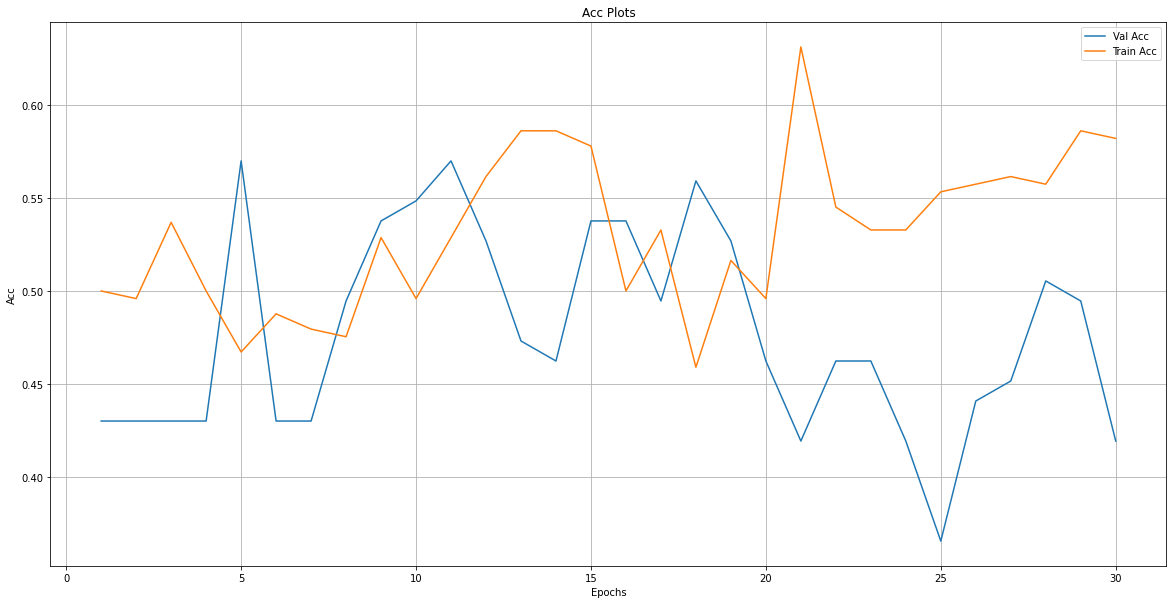

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

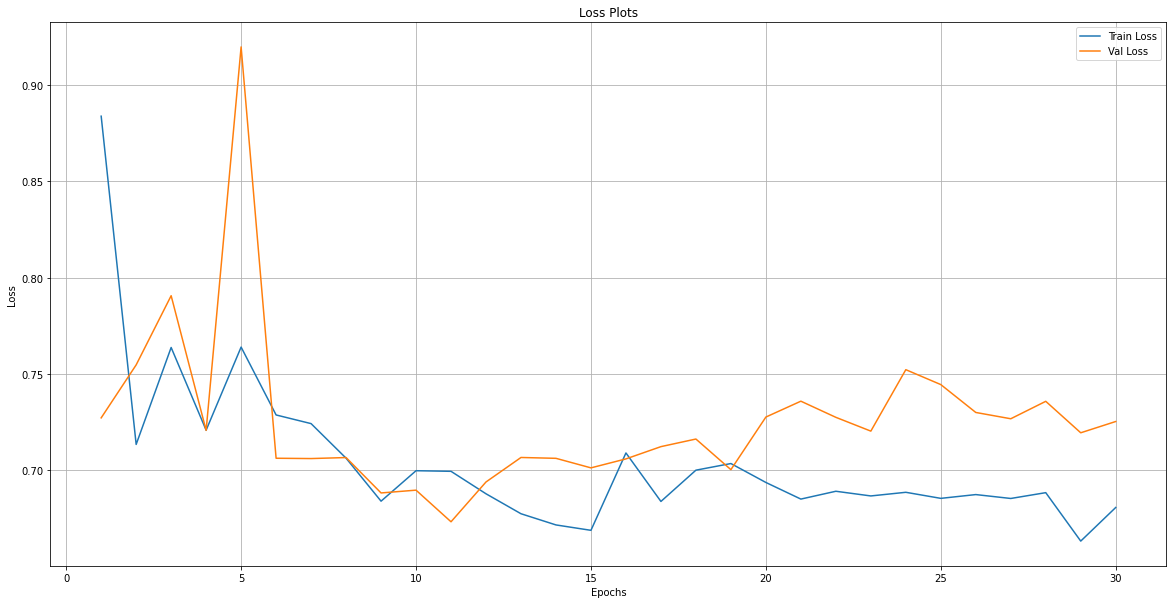

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.4500


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/mobilenetv2_on_hymeno.pth')